# 金肯特纳改进版

In [1]:
#encoding="utf-8"
import pandas as pd
import time 
import json
import requests
import numpy as np
import talib
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

c:\users\administrator\anaconda3\envs\myproject\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\administrator\anaconda3\envs\myproject\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\administrator\anaconda3\envs\myproject\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
# 获取火币或者T8或者币安历史合约K线数据
def get_future_klinedata0(platform, symbol):
    if platform == 'huobi':
        try:
            now = int(time.time())
            start_time = now - 86400*1000
            contract_code = "{}-usdt".format(symbol).upper()
            url = huobifuture_api_url + '/linear-swap-ex/market/history/kline?contract_code={}&period=1day&from={}&to={}'.format(
                contract_code, start_time, now)
            res = requests.get(url)
            resdict = json.loads(res.content.decode())
            df = pd.DataFrame()
            df['close'] = [i['close'] for i in resdict['data']]
            df['high'] = [i['high'] for i in resdict['data']]
            df['low'] = [i['low'] for i in resdict['data']]
            df['open'] = [i['open'] for i in resdict['data']]
        except Exception as e:
            df = pd.DataFrame()
        finally:
            return df
    elif platform == "T8ex":
        try:
            contract_id_dict = {'BTC': 1, 'ETH': 2, 'LINK': 3, 'EOS': 4, 'FIL': 5, 'LTC': 6, 'UNI': 7, 'DOT': 8,
                                'DOGE': 9}
            contract_id = contract_id_dict[symbol.upper()]
            now = int(time.time())
            start_time = now - 86400*2000
            url = T8ex_kline_url + "?contractId={}&from={}&to={}&resolution={}".format(contract_id, start_time * 1000,now * 1000,"1D")
            res = requests.get(url).json()
            df = pd.DataFrame()
            df['close'] = [i[4] for i in res]
            df['high'] = [i[2] for i in res]
            df['low'] = [i[3] for i in res]
            df['open'] = [i[1] for i in res]
        except Exception as e:
            df = pd.DataFrame()
        finally:
            return df

    elif platform == "binance":
        try:
            url = 'https://dapi.binance.com/dapi/v1/continuousKlines'
            pair = "{}usd".format(symbol).upper()
            now = int(time.time())
            start_time = now - 86400 * 400
            data = {'pair': pair, 'contractType': "PERPETUAL", 'interval': '1d', 'starttime': start_time * 1000,
                    'endtime': now * 1000}
            res = requests.get(url, params=data, timeout=1).json()
            df = pd.DataFrame()
            df['high'] = [i[2] for i in res]
            df['low'] = [i[3] for i in res]
            df['close'] = [i[4] for i in res]
        except Exception as e:
            df = pd.DataFrame()
        finally:
            return df

In [3]:
contract_id_dict = {'BTC': 1, 'ETH': 2, 'LINK': 3, 'EOS': 4, 'FIL': 5, 'LTC': 6, 'UNI': 7, 'DOT': 8,'DOGE': 9}

In [4]:
T8ex_kline_url="http://47.241.181.195:1060/contract-market/history"
huobifuture_api_url='https://api.btcgateway.pro'
df=get_future_klinedata0("huobi","doge")
df['high/low/close']=(df['high']+df['low']+df['close'])/3
hlc=np.array(df['high/low/close'].values.tolist())

In [5]:
df['hlc_MA']=df['high/low/close'].ewm(14).mean()

In [6]:
hlc_ema=talib.EMA(hlc,14)

In [7]:
df['hlc_MA']=hlc_ema

In [8]:
# 收盘价
close = np.array(df['close'])
# 最高价
high = np.array(df['high'])
# 最低价
low = np.array(df['low'])
# 获取最新的ATR值
atr = talib.ATR(high, low, close, timeperiod=14)
df['atr']=atr

In [9]:
df['up']=df['hlc_MA']+0.8*df['atr']
df['down']=df['hlc_MA']-0.8*df['atr']

In [10]:
df['buy']=np.where(df['open']>df['up'],1,0)
df['sell']=np.where(df['open']<df['down'],1,0)

In [11]:
#双向交易
flag=0
direction=[]
buy_list=df['buy'].values.tolist()
sell_list=df['sell'].values.tolist()
close_list=df['close'].values.tolist()
hlc_list=df['hlc_MA'].values.tolist()
for i in range(len(buy_list)):
    if flag==0:#没有持仓
        if buy_list[i]==1:
            print("-----------{}----------开多".format(i))
            direction.append(1)
            flag=1
        elif sell_list[i]==1:
            print("-----------{}----------开空".format(i))
            direction.append(-1)
            flag=-1
        else:
            direction.append(0)
            flag=0
    elif flag==1:#持有多仓
        if close_list[i]<hlc_list[i]:
            print("-----------{}----------平多".format(i))
            direction.append(0)
            flag=0
        else:
            direction.append(1)
            flag=1
    elif flag==-1:#持有空仓
        if close_list[i]>hlc_list[i]:
            print("-----------{}-----------平空".format(i))
            direction.append(0)
            flag=0
        else:
            direction.append(-1)
            flag=-1

-----------15----------开空
-----------16-----------平空
-----------17----------开多
-----------34----------平多
-----------61----------开多
-----------69----------平多
-----------72----------开空
-----------78-----------平空
-----------89----------开多
-----------119----------平多
-----------129----------开空
-----------140-----------平空
-----------157----------开空
-----------167-----------平空
-----------177----------开空
-----------189-----------平空
-----------195----------开多
-----------198----------平多
-----------207----------开多
-----------223----------平多
-----------238----------开空


<AxesSubplot:>

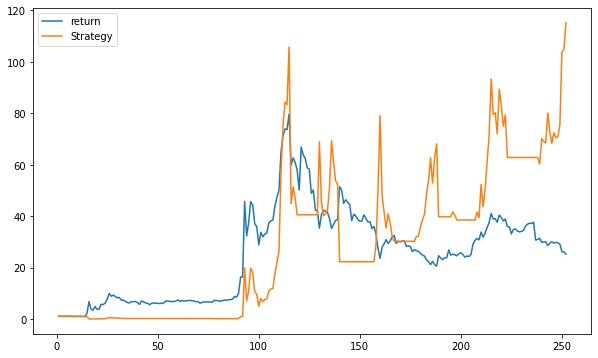

In [13]:
df.loc[:,'return']=np.log(df['close']/df['close'].shift())
df.loc[:,'direction']=np.array(direction)
df.loc[:,'Strategy']=df['direction'].shift()*df['return']*3
df[['return','Strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))